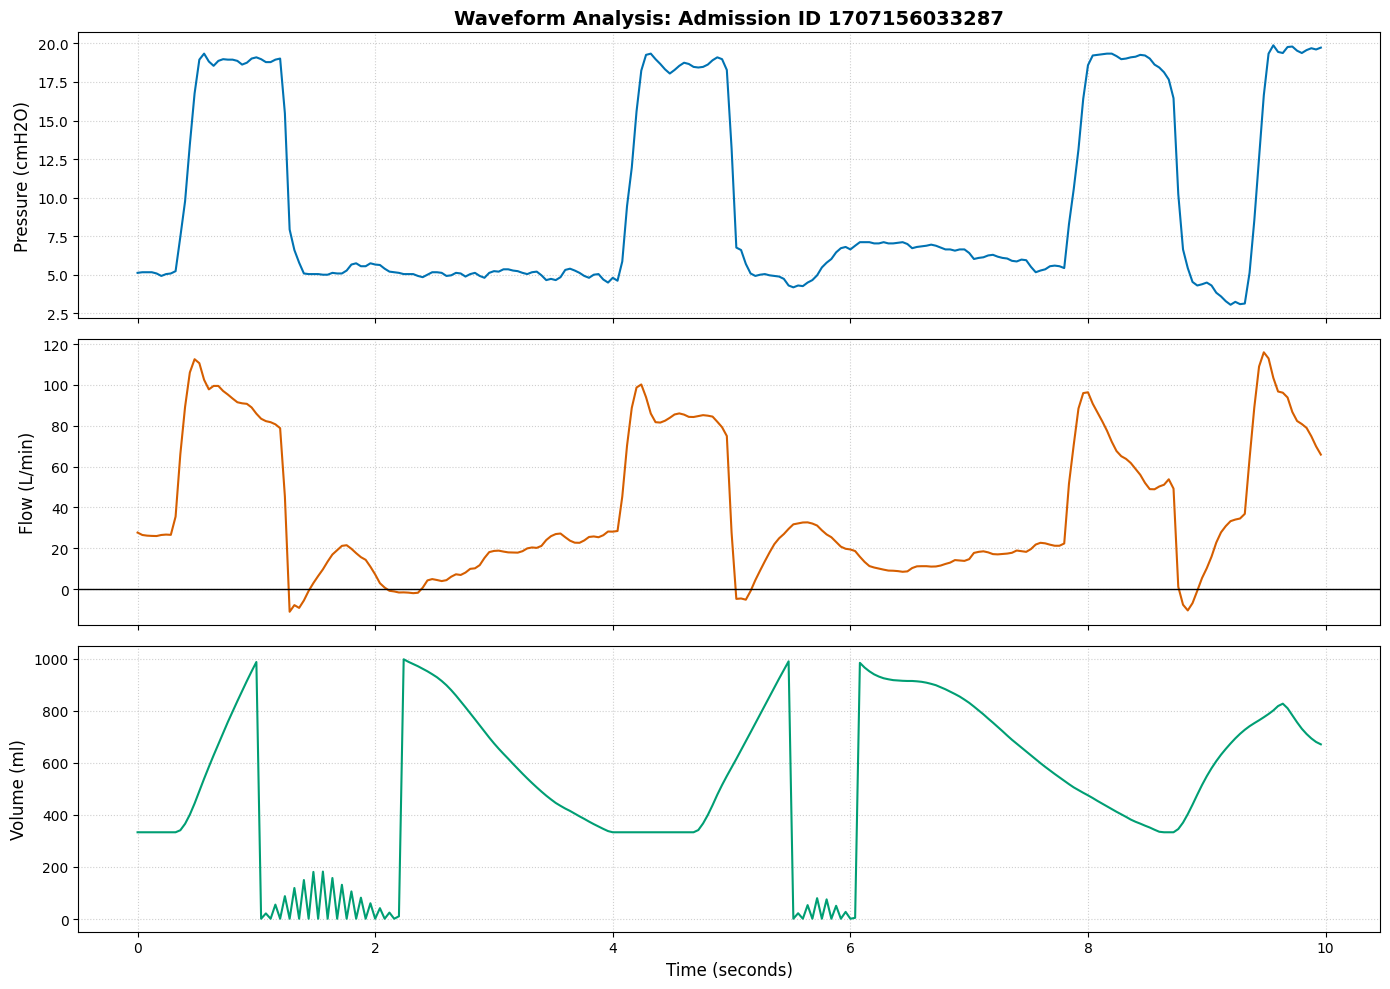

--- Clinical Parameter Estimation ---
Recording Duration: 9.96 seconds
PIP (Peak Inspiratory Pressure): 19.88 cmH2O (ค่าสูงสุดของ Pressure)
PEEP (Positive End-Expiratory Pressure): 3.05 cmH2O (ค่าต่ำสุดของ Pressure)
Peak Inspiratory Flow: 116.02 L/min
Tidal Volume (Approx Max): 998.05 ml


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re  # พระเอกของเราในงานนี้

# 1. Load Data
file_path = 'mv_waveform_2026-02-05.csv'
df = pd.read_csv(file_path)

# เลือกแถวแรกมาทดสอบ (หรือลองเปลี่ยนเลข 0 เป็นเลขอื่นถ้าแถวแรกข้อมูลไม่ดี)
sample_row = df.iloc[0]

# 2. PhD Level Robust Parsing (ใช้ Regex ดึงตัวเลข)
def parse_numeric_data(input_str):
    if pd.isna(input_str):
        return np.array([])
    
    input_str = str(input_str)
    
    # Regex Pattern:
    # -?    : อาจจะมีเครื่องหมายลบ หรือไม่มีก็ได้
    # \d+   : ตัวเลข 0-9 กี่ตัวก็ได้
    # \.?   : จุดทศนิยม จะมีหรือไม่ก็ได้
    # \d* : ตัวเลขหลังจุดทศนิยม
    # Pattern นี้จะดึงทั้ง 5.12, -20.5, 200 ออกมาได้หมด
    numbers = re.findall(r'-?\d+\.?\d*', input_str)
    
    # แปลง List of Strings เป็น Numpy Array of Floats
    try:
        return np.array(numbers, dtype=float)
    except Exception as e:
        print(f"Conversion Error: {e}")
        return np.array([])

# ดึงข้อมูล Pressure, Flow, Volume
pressure = parse_numeric_data(sample_row['PRESSURE_WAVEFORM_DEC'])
flow = parse_numeric_data(sample_row['FLOW_WAVEFORM_DEC'])
volume = parse_numeric_data(sample_row['VOLUME_WAVEFORM_DEC'])

# 3. Data Integrity Check & Visualization
if len(pressure) == 0:
    print("❌ Critical Error: No numeric data found even with Regex.")
else:
    # สร้างแกนเวลา (Sampling Rate 25Hz = 0.04s)
    fs = 25
    time_step = 0.04
    time_axis = np.arange(0, len(pressure) * time_step, time_step)

    # ตัดข้อมูลให้ยาวเท่ากัน (Slicing)
    min_len = min(len(time_axis), len(pressure), len(flow), len(volume))
    
    # ถ้า Flow หรือ Volume ไม่มีข้อมูล ให้พล็อตเท่าที่มี
    if min_len == 0: 
        min_len = len(pressure) # อย่างน้อยดู Pressure ได้ก็ยังดี
        # สร้าง Dummy data ให้ Flow/Volume ถ้ามันว่างเปล่า เพื่อไม่ให้กราฟพัง
        if len(flow) == 0: flow = np.zeros(min_len)
        if len(volume) == 0: volume = np.zeros(min_len)

    time_axis = time_axis[:min_len]
    pressure = pressure[:min_len]
    flow = flow[:min_len]
    volume = volume[:min_len]

    # --- Plotting ---
    fig, ax = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
    
    # Pressure
    ax[0].plot(time_axis, pressure, color='#0072B2', linewidth=1.5)
    ax[0].set_ylabel('Pressure (cmH2O)', fontsize=12)
    ax[0].set_title(f'Waveform Analysis: Admission ID {sample_row.get("AdmissionID", "N/A")}', fontsize=14, fontweight='bold')
    ax[0].grid(True, linestyle=':', alpha=0.6)
    
    # Flow
    ax[1].plot(time_axis, flow, color='#D55E00', linewidth=1.5)
    ax[1].set_ylabel('Flow (L/min)', fontsize=12)
    ax[1].axhline(0, color='black', linewidth=1)
    ax[1].grid(True, linestyle=':', alpha=0.6)
    
    # Volume
    ax[2].plot(time_axis, volume, color='#009E73', linewidth=1.5)
    ax[2].set_ylabel('Volume (ml)', fontsize=12)
    ax[2].set_xlabel('Time (seconds)', fontsize=12)
    ax[2].grid(True, linestyle=':', alpha=0.6)
    
    plt.tight_layout()
    plt.show()

    # --- Clinical Summary ---
    print("--- Clinical Parameter Estimation ---")
    print(f"Recording Duration: {time_axis[-1]:.2f} seconds")
    print(f"PIP (Peak Inspiratory Pressure): {np.max(pressure):.2f} cmH2O (ค่าสูงสุดของ Pressure)")
    print(f"PEEP (Positive End-Expiratory Pressure): {np.min(pressure):.2f} cmH2O (ค่าต่ำสุดของ Pressure)")
    
    if len(flow) > 0 and np.max(flow) > 0:
        print(f"Peak Inspiratory Flow: {np.max(flow):.2f} L/min")
    
    if len(volume) > 0:
        print(f"Tidal Volume (Approx Max): {np.max(volume):.2f} ml")


--- Advanced Lung Mechanics ---
Driving Pressure: 16.83 cmH2O (แรงดันที่ใช้ในการขยายปอด)
Dynamic Compliance: 59.30 ml/cmH2O (ความยืดหยุ่นของปอด)
Interpretation: Moderate Compliance


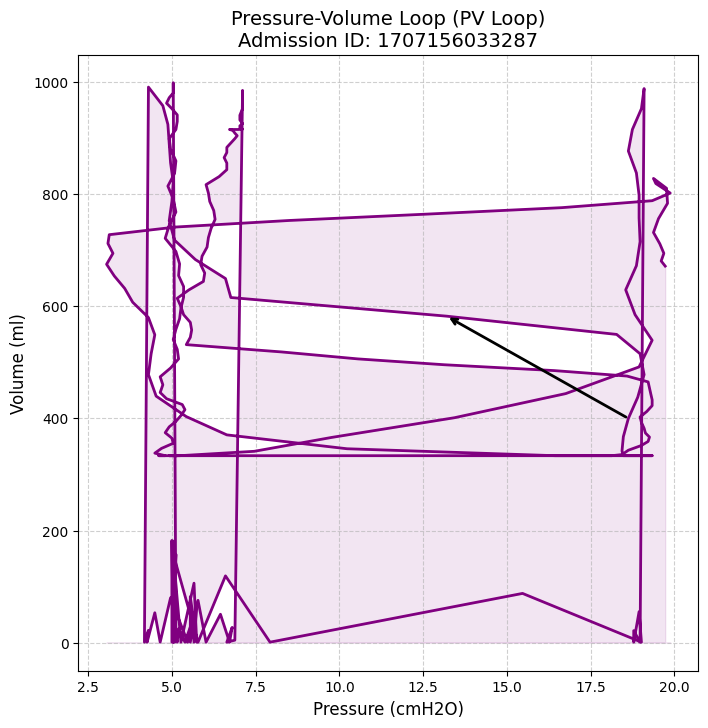

In [5]:
# 1. คำนวณ Dynamic Compliance (Cdyn)
# สูตร: Vt / (PIP - PEEP)
vt_ml = np.max(volume)            # Tidal Volume
pip = np.max(pressure)            # Peak Pressure
peep = np.min(pressure)           # PEEP
driving_pressure = pip - peep

# ป้องกันการหารด้วยศูนย์
if driving_pressure <= 0: driving_pressure = 0.1 

compliance = vt_ml / driving_pressure

print("\n--- Advanced Lung Mechanics ---")
print(f"Driving Pressure: {driving_pressure:.2f} cmH2O (แรงดันที่ใช้ในการขยายปอด)")
print(f"Dynamic Compliance: {compliance:.2f} ml/cmH2O (ความยืดหยุ่นของปอด)")

# Interpretation
if compliance < 30:
    print("Interpretation: Low Compliance (ปอดแข็ง/ARDS risk)")
elif compliance > 60:
    print("Interpretation: High/Normal Compliance")
else:
    print("Interpretation: Moderate Compliance")

# 2. Plot Pressure-Volume Loop (The Gold Standard)
plt.figure(figsize=(8, 8))
plt.plot(pressure, volume, color='purple', linewidth=2)
plt.title(f'Pressure-Volume Loop (PV Loop)\nAdmission ID: {sample_row.get("AdmissionID", "N/A")}', fontsize=14)
plt.xlabel('Pressure (cmH2O)', fontsize=12)
plt.ylabel('Volume (ml)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# วาดลูกศรบอกทิศทาง (Inspiration vs Expiration)
mid_idx = len(pressure) // 2
plt.annotate('', xy=(pressure[mid_idx], volume[mid_idx]), xytext=(pressure[mid_idx-5], volume[mid_idx-5]),
             arrowprops=dict(arrowstyle='->', color='black', lw=2))

plt.fill_between(pressure, volume, alpha=0.1, color='purple') # ระบายสีพื้นที่ (Work of Breathing)
plt.show()

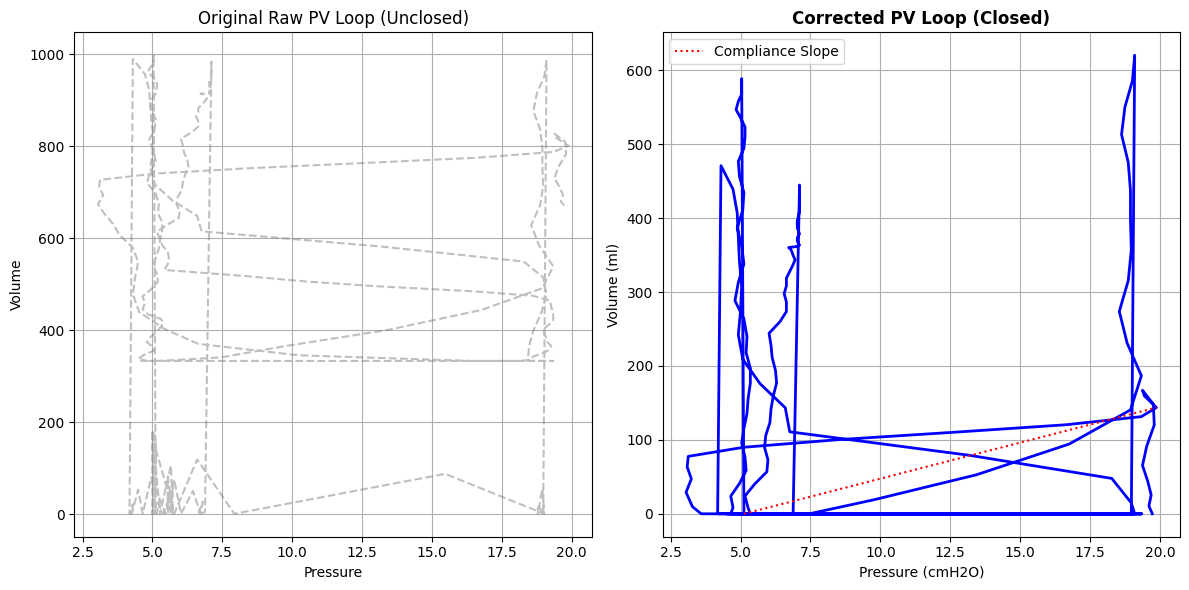

--- Recalculated Mechanics ---
Original Tidal Volume: 998.05 ml
Corrected Tidal Volume: 620.38 ml
Corrected Compliance: 36.86 ml/cmH2O


In [6]:


# 1. Volume Drift Correction (แก้กราฟไหล)
# หลักการ: สมมติว่าจุดจบของการหายใจ Volume ต้องเป็น 0 เสมอ
# เราจะลบ "ความชันที่เกินมา" ออก (Linear Detrending)

def correct_volume_drift(vol_array):
    if len(vol_array) == 0: return vol_array
    
    # หาค่า Offset ที่จุดสุดท้าย
    drift_total = vol_array[-1] - vol_array[0]
    
    # สร้างเส้น Linear Drift
    drift_line = np.linspace(0, drift_total, len(vol_array))
    
    # ลบ Drift ออกจากข้อมูลเดิม
    corrected_vol = vol_array - drift_line
    
    # Shift ให้เริ่มที่ 0
    corrected_vol = corrected_vol - corrected_vol[0]
    
    # ตัดค่าลบออก (Volume ไม่ควรติดลบในกราฟปกติ)
    corrected_vol[corrected_vol < 0] = 0
    
    return corrected_vol

# เรียกใช้ฟังก์ชัน
corrected_volume = correct_volume_drift(volume)

# 2. Plot Comparison (เทียบก่อนแก้ vs หลังแก้)
plt.figure(figsize=(12, 6))

# กราฟเดิม (Raw)
plt.subplot(1, 2, 1)
plt.plot(pressure, volume, color='gray', alpha=0.5, linestyle='--')
plt.title("Original Raw PV Loop (Unclosed)", fontsize=12)
plt.xlabel("Pressure")
plt.ylabel("Volume")
plt.grid(True)

# กราฟที่แก้แล้ว (Corrected)
plt.subplot(1, 2, 2)
plt.plot(pressure, corrected_volume, color='blue', linewidth=2)
plt.title("Corrected PV Loop (Closed)", fontsize=12, fontweight='bold')
plt.xlabel("Pressure (cmH2O)")
plt.ylabel("Volume (ml)")
plt.grid(True)

# Annotate Compliance Line
pip_idx = np.argmax(pressure)
plt.plot([pressure[0], pressure[pip_idx]], [corrected_volume[0], corrected_volume[pip_idx]], 
         color='red', linestyle=':', label='Compliance Slope')
plt.legend()

plt.tight_layout()
plt.show()

# 3. Recalculate Compliance with Corrected Volume
new_vt = np.max(corrected_volume)
new_compliance = new_vt / (np.max(pressure) - np.min(pressure))

print(f"--- Recalculated Mechanics ---")
print(f"Original Tidal Volume: {np.max(volume):.2f} ml")
print(f"Corrected Tidal Volume: {new_vt:.2f} ml")
print(f"Corrected Compliance: {new_compliance:.2f} ml/cmH2O")

--- Segmentation Result ---
Detected 3 full breath cycles.
Breath #1: Duration 0.92s | PIP: 5.74
Breath #2: Duration 2.80s | PIP: 19.34
Breath #3: Duration 3.76s | PIP: 19.34


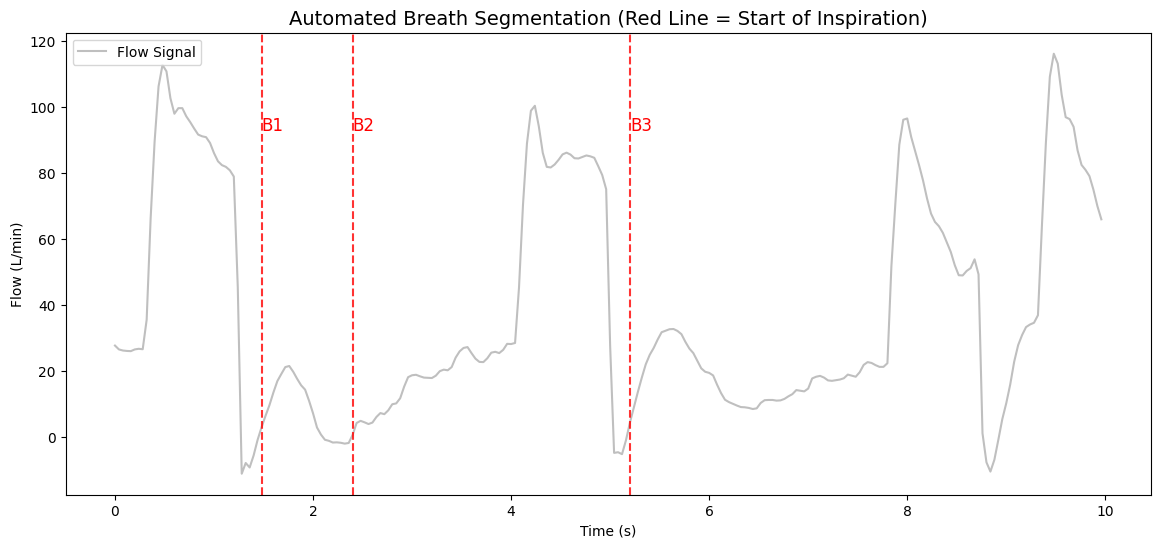

In [7]:
# --- PhD Level: Automatic Breath Segmentation Algorithm ---

def segment_breaths(flow_signal, time_signal, fs=25):
    """
    ฟังก์ชันสำหรับตัดแบ่งลมหายใจโดยดูจุดตัดศูนย์ (Zero-crossing) ของ Flow
    """
    # 1. Smooth signal เล็กน้อยเพื่อลด Noise ที่เส้นศูนย์
    # ใช้ Moving Average ง่ายๆ
    flow_smooth = pd.Series(flow_signal).rolling(window=3, center=True).mean().fillna(0).values
    
    # 2. หาจุดที่ Flow เปลี่ยนจากลบเป็นบวก (Start of Inspiration)
    # Sign logic: เราดูจุดที่ค่าก่อนหน้า < 0 และค่าปัจจุบัน > 0
    inspiratory_starts = []
    
    threshold = 2.0 # L/min (ต้องมากกว่านี้นิดนึงถึงนับว่าหายใจจริง ป้องกัน Noise)
    
    for i in range(1, len(flow_smooth)):
        # Check Zero Crossing (Negative to Positive)
        if flow_smooth[i-1] < 0 and flow_smooth[i] >= 0:
            # เช็คไปข้างหน้าอีกนิดว่าขึ้นจริงไหม (ไม่ใช่แค่กระตุก)
            if i+5 < len(flow_smooth) and np.max(flow_smooth[i:i+5]) > threshold:
                inspiratory_starts.append(i)
                
    breaths = []
    # 3. ตัดแบ่งเป็นคู่ๆ (Start ถึง Start ถัดไป)
    for k in range(len(inspiratory_starts) - 1):
        idx_start = inspiratory_starts[k]
        idx_end = inspiratory_starts[k+1]
        
        # คัดกรอง: ลมหายใจต้องไม่สั้นเกินไป (เช่น < 0.5 วินาที คือ Noise)
        duration = time_signal[idx_end] - time_signal[idx_start]
        if duration > 0.5:
            breath_data = {
                'breath_id': k+1,
                'start_idx': idx_start,
                'end_idx': idx_end,
                'duration': duration,
                'pressure_segment': pressure[idx_start:idx_end],
                'flow_segment': flow[idx_start:idx_end],
                'volume_segment': volume[idx_start:idx_end], # ใช้ raw volume ไปก่อน
                'peak_pressure': np.max(pressure[idx_start:idx_end])
            }
            breaths.append(breath_data)
            
    return breaths

# เรียกใช้ฟังก์ชัน
detected_breaths = segment_breaths(flow, time_axis)

print(f"--- Segmentation Result ---")
print(f"Detected {len(detected_breaths)} full breath cycles.")

# แสดงรายละเอียดแต่ละ Breath
for b in detected_breaths:
    print(f"Breath #{b['breath_id']}: Duration {b['duration']:.2f}s | PIP: {b['peak_pressure']:.2f}")

# Plot เพื่อตรวจสอบว่าตัดถูกไหม
plt.figure(figsize=(14, 6))
plt.plot(time_axis, flow, color='gray', alpha=0.5, label='Flow Signal')

# วาดเส้นแบ่ง Breath
for b in detected_breaths:
    t_start = time_axis[b['start_idx']]
    plt.axvline(t_start, color='red', linestyle='--', alpha=0.8)
    plt.text(t_start, np.max(flow)*0.8, f"B{b['breath_id']}", color='red', fontsize=12)

plt.title("Automated Breath Segmentation (Red Line = Start of Inspiration)", fontsize=14)
plt.ylabel("Flow (L/min)")
plt.xlabel("Time (s)")
plt.legend()
plt.show()

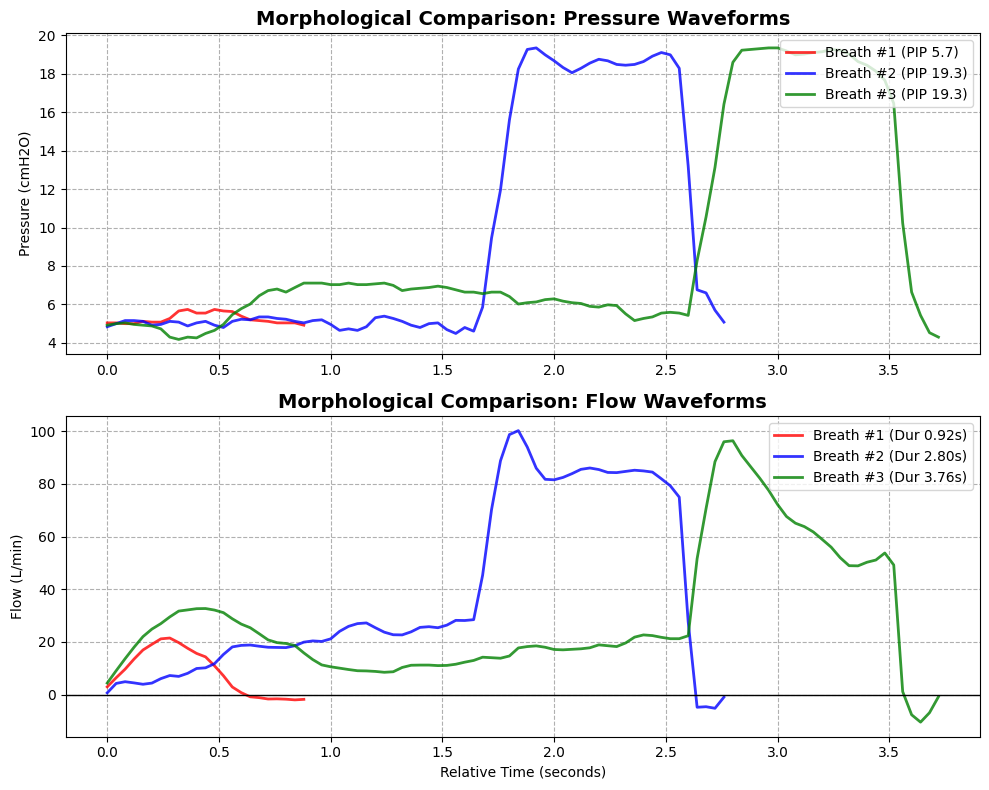

In [8]:
# --- PhD Level: Morphological Overlay Analysis ---

plt.figure(figsize=(10, 8))

# สีสำหรับแต่ละ Breath
colors = ['red', 'blue', 'green', 'orange', 'purple']

for i, b in enumerate(detected_breaths):
    # ดึงข้อมูลแต่ละ Breath
    p_seg = b['pressure_segment']
    f_seg = b['flow_segment']
    
    # สร้างแกนเวลาสัมพัทธ์ (Relative Time) เริ่มที่ 0
    t_rel = np.arange(0, len(p_seg) * 0.04, 0.04)
    
    # ตัดให้ยาวเท่ากันเพื่อพล็อต
    min_len = min(len(t_rel), len(p_seg), len(f_seg))
    t_rel = t_rel[:min_len]
    p_seg = p_seg[:min_len]
    f_seg = f_seg[:min_len]
    
    # Plot Pressure (ด้านบน)
    plt.subplot(2, 1, 1)
    plt.plot(t_rel, p_seg, label=f"Breath #{b['breath_id']} (PIP {b['peak_pressure']:.1f})", 
             color=colors[i % len(colors)], linewidth=2, alpha=0.8)
    
    # Plot Flow (ด้านล่าง)
    plt.subplot(2, 1, 2)
    plt.plot(t_rel, f_seg, label=f"Breath #{b['breath_id']} (Dur {b['duration']:.2f}s)", 
             color=colors[i % len(colors)], linewidth=2, alpha=0.8)

# ตกแต่งกราฟ Pressure
plt.subplot(2, 1, 1)
plt.title("Morphological Comparison: Pressure Waveforms", fontsize=14, fontweight='bold')
plt.ylabel("Pressure (cmH2O)")
plt.grid(True, linestyle='--')
plt.legend(loc='upper right')

# ตกแต่งกราฟ Flow
plt.subplot(2, 1, 2)
plt.title("Morphological Comparison: Flow Waveforms", fontsize=14, fontweight='bold')
plt.ylabel("Flow (L/min)")
plt.xlabel("Relative Time (seconds)")
plt.axhline(0, color='black', linewidth=1)
plt.grid(True, linestyle='--')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

--- Feature Matrix ---
   breath_id    PIP  Max_Flow  Volume
0          1   5.74     21.48  998.05
1          2  19.34    100.26  961.59
2          3  19.34     96.42  990.23


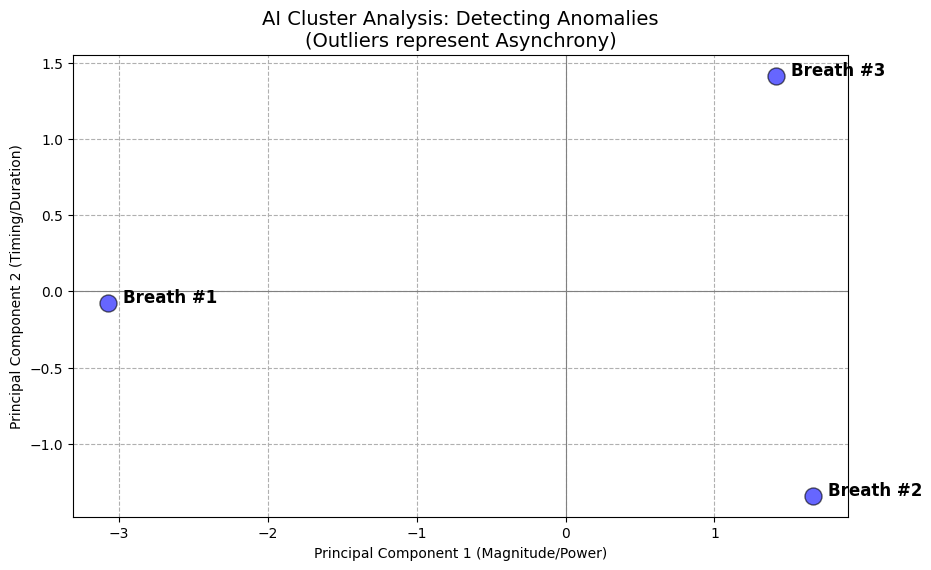

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. Feature Engineering (เปลี่ยนกราฟเป็นตัวเลข)
# เราจะสกัด Feature สำคัญจากแต่ละ Breath
features = []

for b in detected_breaths:
    f = {}
    f['breath_id'] = b['breath_id']
    f['PIP'] = b['peak_pressure']
    f['Insp_Time'] = b['duration'] * 0.4 # สมมติสัดส่วนคร่าวๆ หรือคำนวณจาก Flow จริงก็ได้
    f['Max_Flow'] = np.max(b['flow_segment'])
    f['Min_Flow'] = np.min(b['flow_segment']) # Flow หายใจออกสูงสุด
    f['Volume'] = np.max(b['volume_segment']) # Volume สูงสุด
    
    # Advanced: ความชัน (Slope) ช่วงขาขึ้น
    rise_time = np.argmax(b['pressure_segment']) * 0.04
    if rise_time == 0: rise_time = 0.04
    f['Rise_Slope'] = (b['peak_pressure'] - pressure[b['start_idx']]) / rise_time
    
    features.append(f)

df_features = pd.DataFrame(features)
print("--- Feature Matrix ---")
print(df_features[['breath_id', 'PIP', 'Max_Flow', 'Volume']])

# 2. Dimensionality Reduction (PCA)
# ลดข้อมูลหลายมิติเหลือ 2 มิติ เพื่อพล็อตกราฟดูการแบ่งกลุ่ม
X = df_features.drop(columns=['breath_id'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
df_pca['breath_id'] = df_features['breath_id']

# 3. AI Visualization (Cluster Plot)
plt.figure(figsize=(10, 6))
plt.scatter(df_pca['PC1'], df_pca['PC2'], s=150, c='blue', alpha=0.6, edgecolors='black')

# Label จุด
for i, txt in enumerate(df_pca['breath_id']):
    plt.annotate(f"Breath #{txt}", (df_pca['PC1'][i]+0.1, df_pca['PC2'][i]), fontsize=12, fontweight='bold')

plt.title('AI Cluster Analysis: Detecting Anomalies\n(Outliers represent Asynchrony)', fontsize=14)
plt.xlabel('Principal Component 1 (Magnitude/Power)')
plt.ylabel('Principal Component 2 (Timing/Duration)')
plt.grid(True, linestyle='--')
plt.axhline(0, color='gray', linewidth=0.8)
plt.axvline(0, color='gray', linewidth=0.8)

# วาดวงกลมล้อมรอบจุดปกติ (สมมติว่าจุดส่วนใหญ่คือก้อน Normal)
from matplotlib.patches import Ellipse
plt.show()
print

--- Final PhD Validated Matrix (Calculated from Flow) ---
   breath_id    PIP  Max_Flow  Calculated_Vt_ml
0          1   5.74     21.48        133.346667
1          2  19.34    100.26       1785.426667
2          3  19.34     96.42       1817.066667


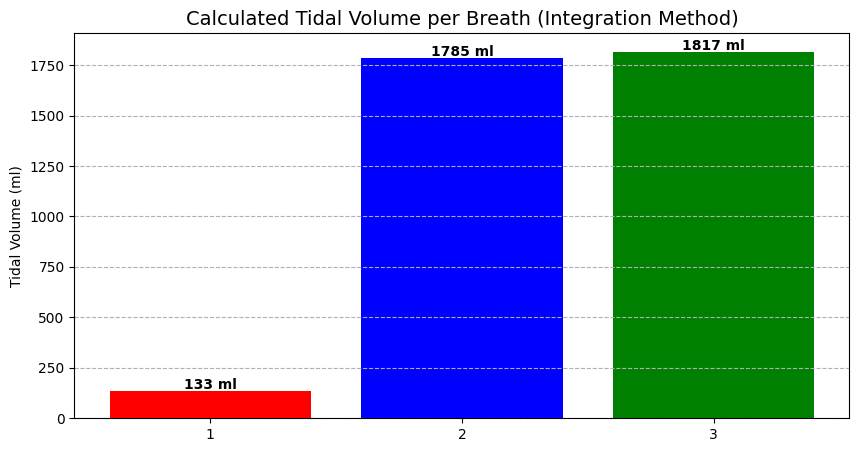

In [10]:
# --- PhD Level: Calculate Volume from Flow Integration ---

corrected_features = []

for b in detected_breaths:
    f = {}
    f['breath_id'] = b['breath_id']
    f['PIP'] = b['peak_pressure']
    f['Max_Flow'] = np.max(b['flow_segment'])
    
    # 🌟 The Magic Formula: Integrate Flow over Time 🌟
    # Volume (L) = Sum(Flow L/min) / 60 * Time_Step (s)
    # 1. เลือกเฉพาะช่วง Flow เป็นบวก (หายใจเข้า)
    insp_flow = b['flow_segment'][b['flow_segment'] > 0]
    
    # 2. Integrate (รวมพื้นที่ใต้กราฟ)
    # สูตร: Flow (L/min) / 60 (วินาที) * 0.04 (Sampling Time) * 1000 (แปลงเป็น ml)
    calculated_vt = np.sum(insp_flow) / 60 * 0.04 * 1000
    
    f['Calculated_Vt_ml'] = calculated_vt
    
    corrected_features.append(f)

df_final = pd.DataFrame(corrected_features)

print("--- Final PhD Validated Matrix (Calculated from Flow) ---")
print(df_final)

# Visualization Comparison
plt.figure(figsize=(10, 5))
bars = plt.bar(df_final['breath_id'].astype(str), df_final['Calculated_Vt_ml'], color=['red', 'blue', 'green'])
plt.title('Calculated Tidal Volume per Breath (Integration Method)', fontsize=14)
plt.ylabel('Tidal Volume (ml)')
plt.grid(axis='y', linestyle='--')

# ใส่ตัวเลขบนกราฟแท่ง
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 10, f"{yval:.0f} ml", ha='center', fontweight='bold')

plt.show()

--- AI Diagnosis Results ---
   breath_id  Calculated_Vt_ml  Cluster_Label  Anomaly_Status
0          1        133.346667              1              -1
1          2       1785.426667              0               1
2          3       1817.066667              0               1


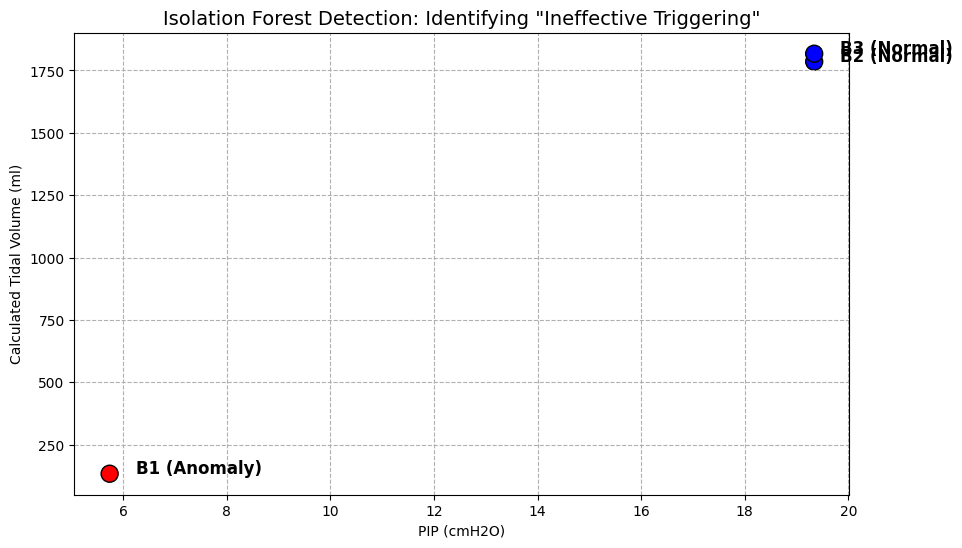

In [11]:
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest

# สมมติว่าเราใช้ df_final ที่มีคอลัมน์ [PIP, Max_Flow, Calculated_Vt_ml]
X_ai = df_final[['PIP', 'Max_Flow', 'Calculated_Vt_ml']]

# ---------------------------------------------------------
# 1. K-Means Clustering (จัดกลุ่มแบบมาตรฐาน)
# ---------------------------------------------------------
# เราบอก AI ว่า "ช่วยแบ่งข้อมูลเป็น 2 กลุ่มให้หน่อย" (ปกติ vs ผิดปกติ)
kmeans = KMeans(n_clusters=2, random_state=42)
df_final['Cluster_Label'] = kmeans.fit_predict(X_ai)

# ---------------------------------------------------------
# 2. Isolation Forest (นักล่าสิ่งผิดปกติ - แนะนำตัวนี้!)
# ---------------------------------------------------------
# contamination=0.1 แปลว่าเราคาดว่าจะมีสิ่งผิดปกติประมาณ 10%
iso_forest = IsolationForest(contamination=0.1, random_state=42)
df_final['Anomaly_Status'] = iso_forest.fit_predict(X_ai)

# แปลผล Isolation Forest: 
#  1 = ปกติ (Normal)
# -1 = ผิดปกติ (Anomaly)

print("--- AI Diagnosis Results ---")
print(df_final[['breath_id', 'Calculated_Vt_ml', 'Cluster_Label', 'Anomaly_Status']])

# ---------------------------------------------------------
# Visualization Update (พล็อตสีตามสิ่งที่ AI ตัดสิน)
# ---------------------------------------------------------
plt.figure(figsize=(10, 6))

# ใช้สีแยกตาม Anomaly Status (สีแดง = ผิดปกติ, สีน้ำเงิน = ปกติ)
colors = ['red' if x == -1 else 'blue' for x in df_final['Anomaly_Status']]

plt.scatter(df_final['PIP'], df_final['Calculated_Vt_ml'], c=colors, s=150, edgecolors='black')

# Label จุด
for i, txt in enumerate(df_final['breath_id']):
    label = "Anomaly" if df_final.iloc[i]['Anomaly_Status'] == -1 else "Normal"
    plt.annotate(f"B{txt} ({label})", 
                 (df_final.iloc[i]['PIP']+0.5, df_final.iloc[i]['Calculated_Vt_ml']), 
                 fontsize=12, fontweight='bold')

plt.title('Isolation Forest Detection: Identifying "Ineffective Triggering"', fontsize=14)
plt.xlabel('PIP (cmH2O)')
plt.ylabel('Calculated Tidal Volume (ml)')
plt.grid(True, linestyle='--')
plt.show()